In [14]:
import warnings
warnings.filterwarnings("ignore")  

import pandas as pd
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords') #Download NLTK Stopwords for machines that do not have it
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer #stemmer

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer #For TF-IDF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from keras import utils
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense, Dropout, Embedding
from tensorflow.python.keras.layers import SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D

import numpy as np
import re
import string
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


sentiment             sadness
content      I miss my friend
Name: 654, dtype: object


,sentiment,content
0,anger,hate to see y'all frown but I'd rather see him...
1,anger,I am their fury. I am their patience. I am a c...
2,anger,@hanktastic1776 @sue51684 @EternalRiteWing If ...
3,anger,@mattstottwrites For me not so much outrage as...
4,anger,@xandraaa5 @amayaallyn6 shut up hashtags are c...


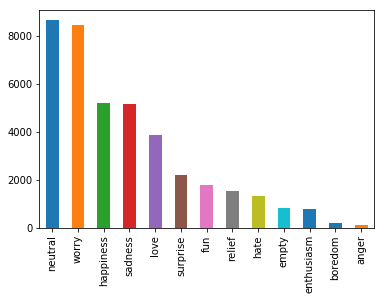

In [28]:
dataframes = {
    "tweets": pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/crowdflower_cs.csv", usecols=range(0,2), encoding='latin1'),
    "anger-train": pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/saif-2018-anger-train-cs.csv", usecols=range(0,2), encoding='latin1'),
    "joy-train": pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/saif-2018-joy-train-cs.csv", usecols=range(0,2), encoding='latin1'),
    "sad-train": pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/saif-2018-sadness-train-cs.csv", usecols=range(0,2), encoding='latin1')
}
print(dataframes["tweets"].iloc[654])

dataframes["tweets"]["sentiment"].value_counts().plot(kind='bar');
dataframes["tweets"]["sentiment"].value_counts()

dataframes["tweets"].head()
dataframes["anger-train"].head()

In [0]:
print(dataframes["tweets"].iloc[1])

tweet_id                                            1956967666
sentiment                                              sadness
author                                               wannamama
content      Layin n bed with a headache  ughhhh...waitin o...
Name: 1, dtype: object


In [0]:
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def stripTagsAndUris(x):
    if x:
        # BeautifulSoup on content
        soup = BeautifulSoup(x, "html.parser")
        # Stripping all <code> tags with their content if any
        if soup.code:
            soup.code.decompose()
        # Get all the text out of the html
        text =  soup.get_text()
        # Returning text stripping out all uris
        return re.sub(uri_re, "", text)
    else:
        return ""

def removePunctuation(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    x = re.sub(r'[^\x00-\x7f]',r' ',x)
    # Removing (replacing with empty spaces actually) all the punctuations
    return re.sub("["+string.punctuation+"]", " ", x)

snow = nltk.stem.SnowballStemmer('english')
stops = set(stopwords.words("english"))
def stemAndRemoveStopwords(x):
    # Removing all the stopwords
    filtered_words = [snow.stem(word) for word in x.split() if word not in stops]
    return " ".join(filtered_words)
    
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)    
    return input_txt

switch_Emotions = {
    #happy angry sad neutral
    #anger boredom empty enthusiasm fun happiness hate love neutral relief sadness surprise worry
        "happy": "happy",
        "angry": "angry",
        "sad": "sad",
        "neutral": "neutral",
    
        "boredom": "boredom",
        "empty": "empty",
        "enthusiasm": "enthusiasm",
        "relief": "relief",
        "surprise": "surprise",
    
        "anger": "angry",
        "fun": "happy",
        "happiness": "happy",
        "hate": "angry",
        "love": "happy",
        "sadness": "sad",
    
        "worry" : "worry",
        "joy" : "happy"
    }

In [0]:
# https://developers.google.com/machine-learning/guides/text-classification/step-3
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 3

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts.values.astype('U'))

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts.values.astype('U'))
    
    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')

    pickle.dump(vectorizer, open("../content/drive/My Drive/Colab Notebooks/models/tfidf.pickle", "wb"))
    pickle.dump(x_train, open("../content/drive/My Drive/Colab Notebooks/models/tfidf_train_features.pickle", "wb"))
    pickle.dump(x_val, open("../content/drive/My Drive/Colab Notebooks/models/tfidf_val_features.pickle", "wb"))
    
    return x_train, x_val

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts.values.astype('U'))

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts.values.astype('U'))
    x_val = tokenizer.texts_to_sequences(val_texts.values.astype('U'))
    
    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    
    pickle.dump(tokenizer, open("../content/drive/My Drive/Colab Notebooks/models/tokenizer.pickle", "wb"))
    pickle.dump(x_train, open("../content/drive/My Drive/Colab Notebooks/models/tok_train_features.pickle", "wb"))
    pickle.dump(x_val, open("../content/drive/My Drive/Colab Notebooks/models/tok_val_features.pickle", "wb"))
    
    return x_train, x_val, tokenizer.word_index

In [0]:
for df in dataframes.values():
    df["content"] = np.vectorize(remove_pattern)(df["content"], "@[\w]*")
    df["content"] = df["content"].map(stripTagsAndUris)
    df["content"] = df["content"].map(removePunctuation)
    df["content"] = df["content"].map(stemAndRemoveStopwords)

    df["sentiment"] = df["sentiment"].map(switch_Emotions)

sentiment            sad
content      miss friend
Name: 654, dtype: object



,sentiment,content
0,empty,know listenin bad habit earlier start freakin ...
1,sad,layin n bed headach ughhhh waitin call
2,sad,funer ceremoni gloomi friday
3,enthusiasm,want hang friend soon
4,neutral,want trade someon houston ticket one


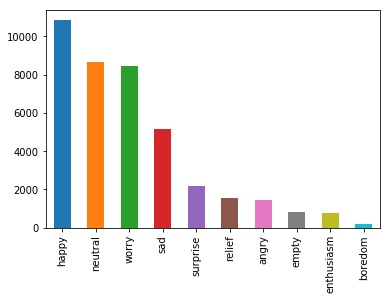

In [0]:
print(dataframes["tweets"].iloc[654])
print()
dataframes["tweets"]["sentiment"].value_counts().plot(kind='bar');
dataframes["tweets"]["sentiment"].value_counts()
dataframes["tweets"].head()

sentiment                                             angry
content      big fan found logic right support offens anyon
Name: 654, dtype: object



,sentiment,content
0,angry,hate see frown rather see smile anger
1,angry,furi patienc convers anger
2,angry,watch un speech see resent toward us american ...
3,angry,much outrag h use femal bodi sell someth anger
4,angry,shut hashtag cool offend


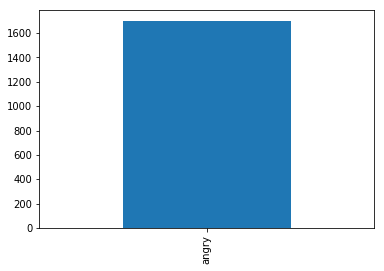

In [0]:
print(dataframes["anger-train"].iloc[654])
print()
dataframes["anger-train"]["sentiment"].value_counts().plot(kind='bar');
dataframes["anger-train"]["sentiment"].value_counts()
dataframes["anger-train"].head()

,sentiment,content
24581,happy,guin got 2 new toy mom dad hous hooray free stuff
21915,surprise,oh wow fast life go 6 month ya xd
27021,happy,went outsid pick flower marina love pick flowe...
12968,neutral,back home
41482,angry,new madden 16 video gonna xbox ahol go struggl


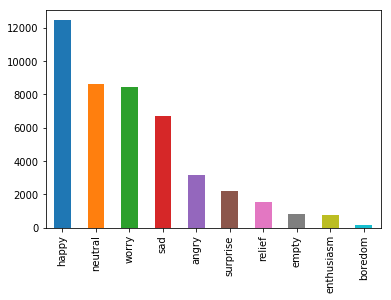

In [33]:
df_traindata = pd.concat([dataframes["tweets"], dataframes["anger-train"], dataframes["joy-train"], dataframes["sad-train"]], ignore_index=True)
#print(df_traindata)
df_traindata = df_traindata.astype(str)
df_traindata = df_traindata.reindex(np.random.permutation(df_traindata.index))

df_traindata["sentiment"].value_counts().plot(kind='bar');
df_traindata["sentiment"].value_counts()

df_traindata.head()

In [0]:
#Read CSV
df_traindata = pd.read_csv("../content/drive/My Drive/Colab Notebooks/datasets/tweets+anger+joy+sad_tcs_dropped.csv", header = 0)
df_traindata.astype(str)

df_traindata = df_traindata.reindex(np.random.permutation(df_traindata.index))
print(df_traindata)

      sentiment                                            content
8296        sad  suck serious hope feel better soon need come n...
8633        sad                                  parti tonight jig
4426        sad  look old stuff found record old band well band...
4362        sad  5 season sorri notic ur previous updat sis gon...
2714        sad            feel way 9 hour sleep still exhaust ahh
4269    neutral  would like 1800 1000 mile gas price crazi im a...
935       angry  imagin bitter bias date send threat partner li...
3275    neutral                            desper go venic beinnal
2         happy  love boy make happi look sexiest plain black b...
12389     angry                 way 2 work damn sinus headach suck
3776      happy               like put fruiti articl websit permit
10749     angry          im ground tonight hate stupid silent mode
4517        sad  intern student today sooo much fun sixflag fri...
746       angry                                               

sad        6698
neutral    6698
happy      6698
angry      3134
Name: sentiment, dtype: int64

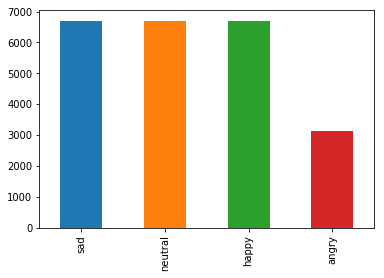

In [34]:
df_counts = df_traindata["sentiment"].value_counts()

#Make different counts equal
s_count, h_count, n_count, a_count = [0 for _ in range(4)]
# min_count = min(df_counts["happy"], df_counts["angry"], df_counts["neutral"], df_counts["sad"])
min_count = min(df_counts["happy"], df_counts["neutral"], df_counts["sad"])
for index, row in df_traindata.iterrows():
  sentiment = row["sentiment"]
  if (sentiment == "sad"):
    if (s_count < min_count):
      s_count+=1
      continue
    else:
      df_traindata.drop(index,inplace=True)
      continue
  if (sentiment == "happy"):
    if (h_count < min_count):
      h_count+=1
      continue
    else:
      df_traindata.drop(index, inplace=True)
      continue
  if (sentiment == "neutral"):
    if (n_count < min_count):
      n_count+=1
      continue
    else:
      df_traindata.drop(index, inplace=True)
      continue
  if (sentiment == "angry"):
#     if (a_count < min_count):
#       a_count+=1
#       continue
#     else:
#       df_traindata.drop(index, inplace=True)
      continue
  df_traindata.drop(index, inplace=True)
    
print()
#print(s_count, min_count)
#plot distribution of sentiments
df_traindata["sentiment"].value_counts().plot(kind='bar');
df_traindata["sentiment"].value_counts()

In [0]:
# Saving to file
name = "tweets+anger+joy+sad"
df_traindata.to_csv("../content/drive/My Drive/Colab Notebooks/datasets/" + name + "_tcs_dropped.csv", index=False)

In [0]:
def mlp_model(layers, dropout_rate, input_shape):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units = 4
    op_activation = "softmax"
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=op_units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units = 4
    op_activation = "softmax"
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
#     if use_pretrained_embedding:
#         model.add(Embedding(input_dim=num_features,
#                             output_dim=embedding_dim,
#                             input_length=input_shape[0],
#                             weights=[embedding_matrix],
#                             trainable=is_embedding_trainable))
#     else:
    model.add(Embedding(input_dim=num_features,
                        output_dim=embedding_dim,
                        input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_normal',
                                  depthwise_initializer='random_normal',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_normal',
                                  depthwise_initializer='random_normal',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_normal',
                              depthwise_initializer='random_normal',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_normal',
                              depthwise_initializer='random_normal',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model


In [0]:
def train_ngram_model(x_train,
                      y_train,
                      x_val,
                      y_val,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """

    # Create model instance.
    model = mlp_model(layers=layers,
                      dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:])

    # Compile model with learning parameters.
    loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adamax(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, y_val),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    y_pred = model.predict_classes(x_val)
    print(classification_report(y_val, y_pred))
    
    # Save model.
    model.save("../content/drive/My Drive/Colab Notebooks/models/model-ngram.h5")
    return history['val_acc'][-1], history['val_loss'][-1]

In [0]:
def train_seq_model(x_train,
                    y_train,
                    x_val,
                    y_val,
#                     word_index,
                    learning_rate=1e-3,
                    epochs=1000,
                    batch_size=128,
                    blocks=2,
                    filters=64,
                    dropout_rate=0.2,
                    embedding_dim=200,
                    kernel_size=3,
                    pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    TOP_K = 20000
    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
#     num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                         filters=filters,
                         kernel_size=kernel_size,
                         embedding_dim=embedding_dim,
                         dropout_rate=dropout_rate,
                         pool_size=pool_size,
                         input_shape=x_train.shape[1:],
                         num_features=20000)

    # Compile model with learning parameters.
    loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adamax(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, y_val),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    y_pred = model.predict_classes(x_val)
    print(classification_report(y_val, y_pred))
    
    # Save model.
    model.save("../content/drive/My Drive/Colab Notebooks/models/model-sepcnn.h5")
    return history['val_acc'][-1], history['val_loss'][-1]

In [36]:
data_x = df_traindata["content"]
data_y = df_traindata["sentiment"]

# Get the data.
train_texts, val_texts, train_labels, val_labels = train_test_split(data_x, data_y, test_size = 0.10, random_state = 42)

# Vectorize texts.
x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
x_seq_train, x_seq_val, word_index = sequence_vectorize(train_texts, val_texts)
print(x_train.shape)

#Transform text labels to hot-encoded matrix labels
# [angry, happy, neutral, sad]
encoder = LabelEncoder()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_val = encoder.transform(val_labels)

#Call this to hot-encode matrix labels
# 1. 0. 0. 0. 
# 0. 1. 0. 0.
# 0. 0. 1. 0.
# 0. 0. 0. 1.
# num_classes = np.max(y_train) + 1
# y_train = utils.to_categorical(y_train, num_classes)
# y_val = utils.to_categorical(y_val, num_classes)
print(y_train)

(20905, 9120)
[1 2 0 ... 2 3 2]


In [44]:
train_ngram_model(x_train, y_train, x_val, y_val, units = 64, learning_rate=0.99e-3, layers=2, dropout_rate = 0.2, epochs=300)

Train on 20905 samples, validate on 2323 samples
Epoch 1/300
 - 3s - loss: 1.3688 - acc: 0.3142 - val_loss: 1.3511 - val_acc: 0.3508
Epoch 2/300
 - 3s - loss: 1.3432 - acc: 0.3523 - val_loss: 1.3303 - val_acc: 0.4090
Epoch 3/300
 - 3s - loss: 1.3262 - acc: 0.3814 - val_loss: 1.3157 - val_acc: 0.4361
Epoch 4/300
 - 3s - loss: 1.3131 - acc: 0.4057 - val_loss: 1.3035 - val_acc: 0.4709
Epoch 5/300
 - 3s - loss: 1.2993 - acc: 0.4297 - val_loss: 1.2911 - val_acc: 0.4895
Epoch 6/300
 - 3s - loss: 1.2882 - acc: 0.4356 - val_loss: 1.2789 - val_acc: 0.5127
Epoch 7/300
 - 3s - loss: 1.2741 - acc: 0.4521 - val_loss: 1.2659 - val_acc: 0.5140
Epoch 8/300
 - 3s - loss: 1.2603 - acc: 0.4587 - val_loss: 1.2532 - val_acc: 0.5209
Epoch 9/300
 - 3s - loss: 1.2467 - acc: 0.4698 - val_loss: 1.2403 - val_acc: 0.5269
Epoch 10/300
 - 3s - loss: 1.2326 - acc: 0.4773 - val_loss: 1.2273 - val_acc: 0.5248
Epoch 11/300
 - 3s - loss: 1.2206 - acc: 0.4889 - val_loss: 1.2144 - val_acc: 0.5265
Epoch 12/300
 - 3s - loss

(0.6022385, 0.9744020563438438)

In [0]:
# train_seq_model(x_train, y_train, x_val, y_val, learning_rate=1e-3, dropout_rate = 0.2, epochs=200)